# Recurrent Neural Networks
Recurrent neural network is a type of network architecture that accepts variable inputs and variable outputs, which contrasts with the vanilla feed-forward neural networks. We can also consider input with variable length, such as video frames and we want to make a decision along every frame of that video.

## Process Sequences
![sequence](img/sequence.png)

* One-to-one
    * This is the classic feed forward neural network architecture, with one input and we expect one output.

* One-to-many
    * This can be thought of as image captioning. We have one image as a fixed size input and the output can be words or sentences which are variable in length.

* Many-to-one
    * This is used for sentiment classification. The input is expected to be a sequence of words or even paragraphs of words. The output can be a regression output with continuous values which represent the likelihood of having a positive sentiment.

* Many-to-many
    * This model is ideal for machine translation like the one we see on Google translate. The input could an English sentence which has variable length and the output will be the same sentence in a different language which also has variable length. The last many to many model can be used for video classification on frame level. Feed every frame of a video into the neural network and expect an output right away. However, since frames are generally dependent on each other, it is necessary for the network to propagate its hidden state from the previous to the next. Thus, we need recurrent neural network for this kind of task.

## Computational Graph
Instead of imagining that hidden state is being *recurrently* fed back into the network, it's easier to visualize the process if we unroll the operation into a computational graph that is composed to many time steps. (*The concept of hidden state and mathematical formulation will be explained in the next section.*)

For example, we begin with a zero'ed vector as our hidden state on the left. We feed it into the network along with our first input. When we receive the next input, we take the new hidden state and feed it into the network again with the second input. The procoess goes on until the point we wish to compute the final output of the network.

![computational-graph-1](img/computational-graph-1.png)

We use the same set of weight for every time step of the computation.

![computational-graph-2](img/computational-graph-2.png)

### Many-to-many
For the many-to-many case, we compute a `y[t]` and the loss for every time step. At the end we simply sum up the loss of all the time steps and count that as our total loss of the network. 

When we think about the back propagation for this model, we will have a separate gradient for W flowing from each of those time steps and then the final gradient for W will be the sum of all those individual time step gradients. *Imagine that we have some sort of ground-truth label for every step of the sequence*:


![computational-graph-many-to-many](img/computational-graph-many-to-many.png)

### Many-to-one
If we have this many to one situation, we make the decision based on the final hidden state of this network. This final hidden state summarizes all of the context from the entire sequence. 


![computational-graph-many-to-one](img/computational-graph-many-to-one.png)

### One-to-many
If we have this one to many situation, where we want to receive a fixed size input and produce a variable length output, then you would commonly use that fixed size input to initialize the hidden state and then let the network to propagate and evolve the hidden state forward. 


![computational-graph-one-to-many](img/computational-graph-one-to-many.png)

### Squence to Sequence
For the sequence to sequence models where you might want to do something like machine translation, this is a combination of **many-to-one** and **one-to-many** architecture. We proceed in two stages, (1) the encoder receives a variably sized input like an english sentence and performs encoding into a hidden state vector, (2) the decoder receives the hidden state vector and produces a variably sized output. The motivation of using this architecture is modularity. We can easily swap out encoder and decoder for different type of language translation.

## Mathematical Formulation
We can process a sequence of vectors **x** applying a recurrence formula at every time step:

$$
h_{t} = f_{W}(h_{t - 1}, x_{t})
$$

Time step of an input vector is represented by `x[t]` and time step of a hidden state is represented by `h[t]`. Thus we can think of `h[t - 1]` as the previous hidden state. The production of hidden state is simply a matrix muplitication of input and hidden state by some weights **W**.

**NOTE**: The same function and same set of parameters are used at every time step.

### Forward Propagation Example
Here's a simple one-to-many vanilla recurrent neural network example in functional form. If we were to produce `h[t]`, we need some weight matrices, `h[t-1]`, `x[t]` and a non-linearity `tanh`.

$$
h_{t} = tanh(W_{hh}h_{t-1} + W_{xh}x_{t} + B_{h})
$$

Since this is a **one-to-many** network, we'd want to produce an output `y[t]` at every timestep, thus, we need another weight matrix that accepts a hidden state and project it to an output.

$$
y_{t} = W_{hy}h_{t} + B_{y}
$$

In [9]:
import numpy as np


np.random.seed(0)
class RecurrentNetwork(object):
    """When we say W_hh, it means a weight matrix that accepts a hidden state and produce a new hidden state. 
    Similarly, W_xh represents a weight matrix that accepts an input vector and produce a new hidden state. This
    notation can get messy as we get more variables later on with LSTM and I simplify the notation a little bit in
    LSTM notes.
    """
    def __init__(self):
        self.hidden_state = np.zeros((3, 3))
        self.W_hh = np.random.randn(3, 3)
        self.W_xh = np.random.randn(3, 3)
        self.W_hy = np.random.randn(3, 3)
        self.Bh = np.random.randn(3,)
        self.By = np.random.rand(3,)
    
    def forward_prop(self, x):
        # The order of which you do dot product is entirely up to you. The gradient updates will take care itself
        # as long as the matrix dimension matches up.
        self.hidden_state = np.tanh(np.dot(self.hidden_state, self.W_hh) + np.dot(x, self.W_xh) + self.Bh)
        
        return self.W_hy.dot(self.hidden_state) + self.By

In [8]:
input_vector = np.ones((3, 3))
silly_network = RecurrentNetwork()

# Notice that same input, but leads to different ouptut at every single time step.
print silly_network.forward_prop(input_vector)
print silly_network.forward_prop(input_vector)
print silly_network.forward_prop(input_vector)

[[-1.73665315 -2.40366542 -2.72344361]
 [ 1.61591482  1.45557046  1.13262256]
 [ 1.68977504  1.54059305  1.21757531]]
[[-2.15023381 -2.41205828 -2.71701457]
 [ 1.71962883  1.45767515  1.13101034]
 [ 1.80488553  1.542929    1.21578594]]
[[-2.15024751 -2.41207375 -2.720968  ]
 [ 1.71963227  1.45767903  1.13200175]
 [ 1.80488935  1.54293331  1.21688628]]


### Back Propagation Example
Using softmax loss and gradient of softmax loss for every time step, we can derive `grad_y`. Now we are tasked with calculating the following gradients:

$$
\frac{\partial L}{\partial W_{hy}} \;, \frac{\partial L}{\partial W_{By}} \;,
\frac{\partial L}{\partial h_{t}} \;, \frac{\partial L}{\partial B_{h}} \;
\frac{\partial L}{\partial W_{hh}} \;, \frac{\partial L}{\partial W_{xh}} \;
$$

**Please look at Character-level Language Model below for detailed backprop example** 

For recurrent neural network, we are essentially backpropagation through time, which means that we are forwarding through entire sequence to compute losses, then backwarding through entire sequence to compute gradients. 

However, this becomes problematic when we want to train a sequence that is very long. For example, if we were to train a a paragraph of words, we have to iterate through many layers before we can compute one simple gradient step. In practice, what people do is an approximation called **truncated backpropagation** through time. Run forward and backward through chunks of the sequence instead of the whole sequence. 

Even though our input sequence can potentially be very long or even infinite, when we are training our model, we will step forward for some number of steps and compute a loss only over this sub sequence of the data. Then backpropagate through this sub-sequence and make a gradient step on the weights. When we move to the next batch, we still have this hidden state from the previous batch of data, we will carry this hidden state forward. The forward pass is unaffected but we will only backpropgate again through this second batch. 

![truncated-backprop](img/truncated-backprop.png)

## Character-leve Language Model
### Training Time
Suppose that we have a character-level language model, the list of possible *vocabularies* is `['h', 'e', 'l', 'o']`.  An example training sequence is `hello`. The same output from hidden layer is being fed to output layer and the next hidden layer, as noted below that `y[t]` is a product of `W_hy` and `h[t]`. Since we know what we are expecting, we can backpropagate the cost and update weights.

The `y[t]` is a prediction for which letter is most likely to come next. For example, when we feed `h` into the network, `e` is the expected output of the network because the only training example we have is `hello`. 

![language-model](img/language-model.png)

### Test Time
At test time, we sample characters one at a time and feed it back to the model to produce a whole sequence of characters (which makes up a word.) We seed the word with a prefix like the letter **h** in this case. The output is a softmax vector which represents probability. We can use it as a probability distribution and perform sampling.

**This means EACH character has some chance to be selected** Samplng technique gives us more diversity in the output. This is evident in sentence construction. Given a prefix, we can have multiple words and phrases to represent the same idea.

![language-model-test-time](img/language-model-test-time.png)

###  Implementation: Minimal character-level Vanilla RNN model
Let's use the same `tanh` example we had up there to implement a single layer recurrent nerual network. The forward pass is quite easy. Assuming the input is a list of character index, i.e. `a => 0`, `b => 1`, etc..., the target is a list of character index that represents the next letter in the sequence. For example, the target is characters of the word `ensorflow` and the input is `tensorflo`. Given a letter `t`, it should predict that next letter is `e`. 


#### ForwardProp
```python
# Encode input state in 1-of-k representation
input_states[t] = np.zeros((self.input_dim, 1))
input_states[t][input_list[t]] = 1

# Compute hidden state
hidden_states[t] = tanh(dot(self.params['Wxh'], input_states[t]) +
                        dot(self.params['Whh'], hidden_states[t-1]) +
                        self.params['Bh'])

# Compute output state a.k.a. unnomralized log probability using current hidden state
output_states[t] = dot(self.params['Why'], hidden_states[t]) + self.params['By']

# Compute softmax probability state using the output state
prob_states[t] = exp(output_states[t]) / np.sum(exp(output_states[t]))
```

#### BackProp
Now here's the fun part, computing the gradients for backpropagation. First of all, let's remind ourself what our model is.

$$
h_{t} = tanh(W_{hh}h_{t-1} + W_{xh}x_{t} + B_{h})
$$

$$
y_{t} = W_{hy}h_{t} + B_{y}
$$

First compute the gradient of loss with respect to output vector `y`:

$$
\frac{\partial L}{\partial y_{t}}
$$

```python
# Softmax gradient
grad_output = np.copy(prob_states[t])
grad_output[target_list[t]] -= 1
```

Then gradient of loss with respect to `Why`, `h`, and the bias:

$$
\frac{\partial L}{\partial W_{hy}} = \frac{\partial L}{\partial y_{t}} \cdot \frac{\partial y_{t}}{\partial W_{hy}}
$$

$$
\frac{\partial L}{\partial B_{y}} = \frac{\partial L}{\partial y_{t}} \cdot \frac{\partial y_{t}}{\partial B_{y}}
$$

$$
\frac{\partial L}{\partial h_{t}} = \frac{\partial L}{\partial y_{t}} \cdot \frac{\partial y_{t}}{\partial h_{t}}
$$

```python
grads['Why'] += dot(grad_output, hidden_states[t].T)
grads['By'] += grad_output
grad_h = dot(self.params['Why'].T, grad_output) + grad_prev_h # (H, O)(O, H) => (H, H)
```

We need to perform a little u-substitution here to simplify our derivatives. 

$$
h_{t} = tanh(u) + B_{h}
$$

So we find the gradient of loss with respect to `u` and then use that to find rest of the gradients. 

$$
\frac{\partial L}{\partial u} = \frac{\partial L}{\partial h_{t}} \cdot \frac{\partial h_{t}}{\partial u}
$$

$$
\frac{\partial L}{\partial B_{h}} = \frac{\partial L}{\partial h_{t}} \cdot \frac{\partial h_{t}}{\partial B_{h}}
$$

```python
grad_u = (1 - hidden_states[t] * hidden_states[t]) * grad_h
grads['Bh'] += grad_u
```

Finally, we can compute the gradients for the last two parameters:

$$
\frac{\partial L}{\partial W_{xh}} = \frac{\partial L}{\partial u} \cdot \frac{\partial u}{\partial W_{xh}}
$$

$$ 
\frac{\partial L}{\partial W_{hh}} = \frac{\partial L}{\partial u} \cdot \frac{\partial u}{\partial W_{hh}}
$$

$$
\frac{\partial L}{\partial h_{t-1}} = \frac{\partial L}{\partial u} \cdot \frac{\partial u}{\partial h_{t-1}}
$$

```python
grads['Wxh'] += dot(grad_u, input_states[t].T)
grads['Whh'] += dot(grad_u, hidden_states[t-1].T)
grad_prev_h = dot(self.params['Whh'].T, grad_u)
```

In [3]:
import numpy as np
from adagrad import AdaGradOptimizer
from data_util import *
from vanilla_rnn import VanillaRNNModel

hidden_dim = 100
seq_length = 50
learning_rate = 1e-1
text_data, char_to_idx, idx_to_char = load_dictionary("datasets/word_dictionary.txt")
model = VanillaRNNModel(len(char_to_idx), hidden_dim)
optimizer = AdaGradOptimizer(model, learning_rate)

text document contains 727 characters and has 40 unique characters


In [4]:
curr_iter, pointer, epoch_size, total_iters = 0, 0, 100, 20000

steps, losses = [], []
while curr_iter < total_iters:
    if curr_iter == 0 or pointer + seq_length + 1 >= len(text_data):
        prev_hidden_state = np.zeros((hidden_dim, 1))  # Reset RNN memory
        pointer = 0  # Reset the pointer
    
    # Since we are trying to predict next letter in the sequence, the target is simply pointer + 1
    input_list = [char_to_idx[ch] for ch in text_data[pointer:pointer+seq_length]]
    target_list = [char_to_idx[ch] for ch in text_data[pointer+1: pointer+seq_length+1]]
    loss, grads, prev_hidden_state = model.loss(input_list, target_list, prev_hidden_state)
    if curr_iter % epoch_size == 0:
        steps.append(curr_iter)
        losses.append(loss)
        
    optimizer.update_param(grads)
    curr_iter += 1 
    pointer += seq_length

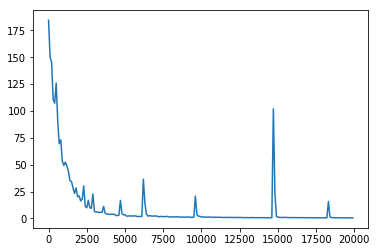

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(steps, losses)
plt.show()

In [6]:
# Pick a random character and sample a 100 characters long sequence (i.e. a sentence.)
letter = 'H'
hidden_state = np.zeros_like((hidden_dim, 1))
_, sampled_indices = model.sample_chars(prev_hidden_state, char_to_idx[letter], 1000)
predicted_text = ''.join(idx_to_char[idx] for idx in sampled_indices)
print "-------------\n%s\n-------------" % predicted_text

-------------

In leav,s aven rooked down one as far as I could
To where it bent in the undergrowth;
Then took in as fa stood
And looked down one as favre lay
Ig perass trg
I sack.
I shene them really about the same,
And both that morning equally lay
In leaverg d re tat morning equally lay
In leaves be stood
And looked down one as far as I could
To whe other, as just as fair,
And having perhaps the better claim,
Because it was grassy and wanted wear;
Though as for that the passing the leaves no stood
And looked down one as far as I could
To where it bent in the undergrowth;
Then took the other, as just as fair,
And having perhaps the shat has saves no step had trodden black.
Oh, I kept the first for another day!
Yet knowing how way leads on to way,
I doubted if I should ever cous the other, as just as fair,
And having perhaps the better claim,
Because it was grassy and wanted wear;
Though as for that the passing there
Had worn  ood ss tn the undergrowth;
Then took the other, as just as

## Multi-layer RNN
We can construct a multi-layer recurrent neural network by stacking layers of RNN together. That is simply taking the output hidden state and feed it into another hidden layer as an input sequence and repeat that process. However, in general RNN does not go very deep due to the exploding gradient problem from long sequence of data. Also for most natural language problems, there isn't a lot of incentive to go deep for every time step. The key thing is long sequence data.

![multi-layer-rnn](img/multi-layer-rnn.png)

$$
h^{layer}_{t} = tanh \begin{pmatrix} W^{layer} \begin{pmatrix} h^{layer - 1}_{t} \\ h^{layer}_{t-1} \end{pmatrix} \end{pmatrix}
$$

In this case, the `W[l]` is a `(hidden_dim, 2 * hidden_dim)` matrix.